# Sequence Tagging
---

<font size="4"> Tagging is the task of labelling each word in a sentence. Examples are: Part-of-Speech (POS) tagging, Named Entity Recognition (NER) and Semantic Role Labelling (SRL).
  
Sequence tagging can be treated as a set of independent classification tasks targeting each individual component of a sequence. However, ideally a model considers context when assigning labels to each component. 

Formally, the challenge in tagging is to learn a function that maps a sequence of observations x = (<i>x<sub>1</sub>,x<sub>2</sub>,....x<sub>n</sub></i>) to a label sequence y = (<i>y<sub>1</sub>,y<sub>2</sub>,...,y<sub>n</sub></i>), where <i>y<sub>i</sub></i> belongs to a set of tags, which in the case of POS tagging would be Noun, Verb, Adjective, or similar.

In some tasks, a chunk in a sequence receives a label, such as <i>Cherno More</i> or <i>Black Sea</i> in "Cherno More is the Bulgarian name of the Black Sea". 

In such cases, it is a standard practice to annotate the data using the <b>IOB scheme</b>.

Each element gets a label indicating whether it occurs in the beginning of chunk X (B-X), inside chunk X (I-x) or outside of any chunk (O).

Common issues in tagging include:
<ul>
<li> Large set of features
<li> Smaller amount of data
<li> Expensive memory and time costs
</ul>

<br>
  
---
In this notebook, we implement an <b> LSTM-based NER system</b> for CONLL2003 dataset.
  
</font>

## Let's start!
---

In [1]:
# The following two lines authorises access to Google Drive:
from google.colab import drive
drive.mount('/content/drive/')

import warnings
warnings.filterwarnings('ignore')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
import numpy as np
import time
import pdb
import torch
import gensim
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

use_cuda = torch.cuda.is_available()
print("cuda device {}available".format("" if use_cuda else "un"))
device = torch.device("cuda:0" if use_cuda else "cpu")

# Parameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 200
BATCH_SIZE = 128 #300
EPOCHS = 50
LSTM_DROPOUT = 0.3

# data dir
data_folder = "/content/drive/My Drive/DLinNLP/Data"
# embeddings folder 
embed_folder = "/content/drive/My Drive/DLinNLP/Embeddings"

cuda device available


In [0]:
word2vec_file = embed_folder+'/vectors.txt'
#embedding_matrix = load_pretrained(word2vec_file)
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_file)


## Data Format
---
<font size="4"> One standard file format for representing tagged pieces of text is CONLL. 
  
A CONLL file contains one token per line and an empty line indicating the end of a sentence. Each token may be annotated by several tab-separated columns indicating information about the token (e.g. token raw form) or differrent tags assigned to it (e.g. syntactic and morphological labels).
</font>

<P>
<table align="left" style="width:100%">
  <tr>
    <td>Welsh</td>
    <td>NNP</td> 
    <td>B-NP</td>
    <td><b>B-ORG</td>
  </tr>
  <tr>
    <td>National</td>
    <td>NNP</td> 
    <td>I-NP</td>
    <td><b>I-ORG</td>
  </tr>
  <tr>
    <td>Farmers</td>
    <td>NNP</td> 
    <td>I-NP</td>
    <td><b>I-ORG</td>
  </tr>
  <tr>
    <td>'</td>
    <td>POS</td> 
    <td>B-NP</td>
    <td><b>I-ORG</td>
  </tr>
  <tr>
    <td>Union</td>
    <td>NNP</td> 
    <td>I-NP</td>
    <td><b>I-ORG</td>
  </tr>
  <tr>
    <td>(</td>
    <td>(</td> 
    <td>O</td>
    <td><b>O</td>
  </tr>
  <tr>
    <td>NFU</td>
    <td>NNP</td> 
    <td>B-NP</td>
    <td><b>B-ORG</td>
  </tr>
  <tr>
    <td>)</td>
    <td>)</td> 
    <td>O</td>
    <td><b>O</td>
  </tr>
  <tr>
    <td>chairman</td>
    <td>NN</td> 
    <td>B-NP</td>
    <td><b>O</td>
  </tr>
  <tr>
    <td>John</td>
    <td>NNP</td> 
    <td>I-NP</td>
    <td><b>B-PER</td>
  </tr>
  <tr>
    <td>Lloyd</td>
    <td>NNP</td> 
    <td>I-NP</td>
    <td><b>I-PER</td>
  </tr>
  <tr>
    <td>said</td>
    <td>VBD</td> 
    <td>B-VP</td>
    <td><b>O</td>
  </tr>
  <tr>
    <td>on</td>
    <td>IN</td> 
    <td>B-PP</td>
    <td><b>O</td>
  </tr>
  <tr>
    <td>BBC</td>
    <td>NNP</td> 
    <td>B-NP</td>
    <td><b>B-ORG</td>
  </tr>
  <tr>
    <td>radio</td>
    <td>NN</td> 
    <td>I-NP</td>
    <td><b>I-ORG</td>
  </tr>
  <tr>
    <td>.</td>
    <td>.</td> 
    <td>O</td>
    <td><b>O</b></td>
  </tr>
  <tr>
    <td><br></tr>
    <td><font size="4"> Here, we read the CONLL 2003 dataset! <font></td>
  </tr>
</table>

<br>
</P> 


In [4]:
def readfile(filename):
    f = open(filename)
    sentences = []
    sentence = []
    for line in f:
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
            if len(sentence) > 0:
                sentences.append(sentence)
                sentence = []
            continue
        splits = line.split(' ')
        sentence.append([splits[0].strip(), splits[-1].strip()])

    if len(sentence) > 0:
        sentences.append(sentence)
        sentence = []
    sentences = [tuple(zip(*l)) for l in sentences]
    return sentences

train_data = np.array(readfile(data_folder+'/train.txt'))
dev_data = np.array(readfile(data_folder+'/dev.txt'))
test_data = np.array(readfile(data_folder+'/test.txt'))

print("train_data shape: ",train_data.shape)
print("One instance of data: ",train_data[0])
print("dev_data shape: ",dev_data.shape)

train_data shape:  (14041, 2)
One instance of data:  [('EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.')
 ('B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O')]
dev_data shape:  (3250, 2)


## Pre-processing 
---

<font size="4">It is common to sort data instances based on their lengths. This way, the lengths of sequences in each batch would be more or less homogeneous. 
<font>

In [0]:
# This reordering is useful for padding
def tensor_reorder(data):
    """reorders tensors from longest to shortest"""
    lengths = [len(i[0]) for i in data]
    max_len = max(lengths)
    lengths = torch.LongTensor(lengths)
    lengths, perm_idx = lengths.sort(0, descending=True)
    data = data[perm_idx]
    return data

train_data = tensor_reorder(train_data)
dev_data = tensor_reorder(dev_data)
test_data = tensor_reorder(test_data)

MAX_LEN = max(len(train_data[0][0]), len(dev_data[0][0])) # we set the maximum length from the max seq in train 

In [0]:
# Here, we create a dictionary that maps all words to indices (for encoding)

all_words = list(set([w for sent in np.concatenate((train_data,dev_data), axis=0) for w in sent[0]]))

word_to_ix = {t:i+2 for i, t in enumerate(all_words)}

word_to_ix['<PAD>'] = 0
word_to_ix['<UNK>'] = 1

# The tagset is simplified (NE categories not included) 
tag_to_ix = {'<PAD>':0, 'B-MISC':1, 'B-LOC':1, 'B-ORG':1, 'B-PER':1,
             'I-MISC':2, 'I-PER':2, 'I-ORG':2, 'I-LOC':2, 'O':3}
ix_to_tag = {0:'<PAD>', 1:'B', 2:'I', 3:'O'}

## If we wanted to consider tags in their entirety:
# all_tags = list(set([tag for sent_tag in train_data for tag in sent_tag[1]]))
# tag_to_ix = {t:i+1 for i, t in enumerate(all_tags)}
# tag_to_ix['<PAD>'] = 0
# ix_to_tag = {v: k for k, v in tag_to_ix.items()}

## Dataset class and Dataloading
---

<font size="4">The standard way to represent a dataset in PyTorch is through the `utils.data.Dataset` class. In order to define your dataset, your custom class should inherit from `Dataset` and override the following two methods:
    
1. `__len__` which returns the size of the dataset  
2. `__getitem__` which receives an index `i`, returning the representation for the i*th* sample in the dataset  

You can define other arbitrary methods depending on your specific requirements.         
    
<font>

In [0]:
# This class representa the dataset.
class CoNLL2003NER(Dataset):

    def __init__(self, X, max_len, word_to_ix, tag_to_ix):
        self.X = X
        self.max_len = max_len
        self.word_to_ix = word_to_ix
        self.tag_to_ix = tag_to_ix
        
    def transform(self, seq, to_ix):
        """Transorm and prepare one data instance"""
        idxs = [to_ix[w] if w in to_ix else 1 for w in seq]
        if len(idxs) >= self.max_len:
            # Truncating
            idxs = idxs[:self.max_len]    
        else:
            # Padding
            idxs += [0]*(self.max_len-len(seq))
        # torch.long tensors are usually used for indexing 
        return torch.tensor(idxs, dtype=torch.long)

    def __len__(self):
        """Return the length of the dataset"""
        return len(self.X)

    def __getitem__(self, idx):
        """Given an index, return its corresponding item in the dataset"""
        return self.transform(self.X[idx][0],self.word_to_ix), \
               self.transform(self.X[idx][1], self.tag_to_ix)

<font size="4"> In order to iterate over a `Dataset` instance, PyTorch provides the `torch.utils.data.DataLoader` which offers the following functionalities:

1.   create batches of data to be fed to a network 
2.   shuffling the data instances 
3.   loading instances using the multiprocessing workers 
    <font>

In [0]:
# Depending on the batch size, `drop_last` might be set to `True` in order to drop the final smaller batch.

params = {'batch_size': BATCH_SIZE,
          'shuffle': False,
          'num_workers': 6,
          'drop_last':True}

params_test = {'batch_size': 1, # batch is set to 1 not to drop any instances here
          'shuffle': False,
          'num_workers': 6,
          'drop_last':True}

train_data = CoNLL2003NER(train_data, MAX_LEN, word_to_ix, tag_to_ix)
train_data_generator = DataLoader(train_data, **params)

dev_data = CoNLL2003NER(dev_data, MAX_LEN, word_to_ix, tag_to_ix)
dev_data_generator = DataLoader(dev_data, **params)

test_data = CoNLL2003NER(test_data, MAX_LEN, word_to_ix, tag_to_ix)
test_data_generator = DataLoader(test_data, **params_test)

In [9]:
train_data.__getitem__(0)

(tensor([ 7277, 18692,   756, 21179, 23229, 23541,  9250,  7591, 12779,  3530,
         20956, 12174, 25311, 10251, 11335, 13646, 24946,  2750,  6646, 18071,
         10986, 23556, 18071, 24946,  6823, 13414,  6992,  1019,   369,  6851,
          6646, 24946, 12176, 23556, 24227,   807,  1019,  5593,  6646, 24946,
          1019,  1978, 23556, 24227, 25644, 23695, 25063,  6646, 24946,  1019,
          3691, 23556, 24227, 25028, 16793,  1019,  2404, 26080, 23556, 24946,
         12176,  6646, 24227,  7352, 12143,  6646, 24946,  1019, 14928, 23556,
         24946,  6876, 12176,  6646, 24946,  1019, 11307, 23556, 24227,   464,
          1019,   150,  6646, 24946, 12176, 23556, 24227, 14915,  8476,  6646,
         24946,  1019, 18247, 23556, 24227,  1652, 16793,  1019, 25349, 26080,
          6646, 24946, 12176, 23556, 24227, 22110,  1019,  1611,  6646, 24946,
         12176, 23556, 17556]),
 tensor([3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 

In [10]:
### TO DO #2 Solution ###   
# Loading pre-trained embbeding
# fill embedding_matrix
USE_PRETRAINED = True
def load_pretrained(file):
    """load a weight matrix from pre-trained weights"""
    model = gensim.models.KeyedVectors.load_word2vec_format(file)
    embedding_dimension = model.vector_size 
    embedding_matrix = np.zeros((len(word_to_ix), EMBEDDING_DIM))   
    UNKOWN = np.random.uniform(-1, 1, embedding_dimension) 

    for word, i in word_to_ix.items():
        if word in model.vocab:
            embedding_matrix[i] = model[word] 
        else:
            embedding_matrix[i] = UNKOWN

    embedding_matrix[word_to_ix['<PAD>']] = np.zeros((embedding_dimension))
    embedding_matrix = torch.from_numpy(embedding_matrix).type(torch.FloatTensor)
    return embedding_matrix

if USE_PRETRAINED:
    word2vec_file = embed_folder+'/vectors.txt'
    embedding_matrix = load_pretrained(word2vec_file)
    print('embedings loaded...')

embedings loaded...


## Define the Model

<font size="4"> In PyTorch, models are defined by creating classes that inherit from `torch.nn.Module`. Defining a model involves two critical steps:
    

1.   Specifying the components of the model in the `__init__` constructor
2.   Outlining the way these components interact in the `forward` method
  </font>

In [0]:
# A simple LSTM Tagger
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, max_len):
        super(LSTMTagger, self).__init__()
        
        # load weights from pre-trained vectors or with random initialization
        if not USE_PRETRAINED:
            self.word_embeddings = nn.Embedding(vocab_size, embedding_dim) 
        else:  
            # load weights from pre-trained vectors 
            self.word_embeddings = nn.Embedding.from_pretrained(embedding_matrix, freeze=False) 
                                                                # freeze default is True            
        ### TO DO #4 Solution ### 
        ### Character Embedding ###

        ### TO DO #3 ####
        ### bi_directional LSTM
        ### Add other layers to the Model ###

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, 
                            dropout=LSTM_DROPOUT, bidirectional=True, num_layers=2)
   
        # The linear layer that maps from hidden space to tag space
        self.hidden2tag = nn.Linear(2*hidden_dim, tagset_size)

    def forward(self, sentence): 
        embeds = self.word_embeddings(sentence)     # SHAPE: [BATCH_SIZE,MAX_LEN,WORD_EMBEDDING_DIM]
        
        ### TO DO (optional) ####   
        # Add packed padded sequences to help the loss ignores computation for PAD labeld
        
        lstm_out, _ = self.lstm(embeds)

        tag_space = self.hidden2tag(lstm_out)
        tag_scores = F.log_softmax(tag_space, dim=-1) 
        return tag_scores

In [12]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(ix_to_tag), MAX_LEN).to(device)

# The negative log likelihood loss. 
# It is useful to train a classification problem with C classes.
loss_function = nn.NLLLoss(ignore_index=0)  
optimizer = optim.Adam(model.parameters(), lr = 0.001) 

print(model)

LSTMTagger(
  (word_embeddings): Embedding(26885, 300)
  (lstm): LSTM(300, 200, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (hidden2tag): Linear(in_features=400, out_features=4, bias=True)
)


In [0]:
### TO DO #1 Solution ###
# Write an early stopping procedure

def early_stop(losses, patience):
    """stop execution if there is consecutive decline/stagnation in the loss values.
       patience determines how quickly we take action. 
    """
    stop = False
    patience += 1
    if len(losses)>patience and min(losses[-patience:])==losses[-patience]:
        stop = True
    return stop

## Training

<font size="4">In PyTorch, you have control over all the stages of the training, from iteration over the data, to adjusting the gradients, calculating the loss and backpropagation given the computed loss. 

The training procedure involves two for-loops. The inner loop is over the batches of the data. Here is where per-batch loss is computed and model parameters are updated using an optimizer. 

The inner loop is composed of the following essential steps:

1. Clear the gradients. Remember that gradients accumulate over time. In each batch, they need to be reset.  

2. Run forward pass and generate an output. 

3. Pass the output and the gold-standard training labels to the loss function to estimate the degree of deviation from the true labels.   

4. Call the `backward()` method on the loss object. This will compute gradients $\frac{\partial loss}{\partial x}$ for every parameter x whose `requires_grad` is set to `True`. In order words, the backward method `back propagates` gradients to each parameter.

5. Perform parameter updates by calling `optimizer.step()`. The optimizer is dependent on the computed gradients to perform this operation. 

The outer loop repeats the inner one for the specified number of epochs. Note that the training procedure should happen in the `training` mode which is set in the beginning of the outer loop.   <font>
  
### Validation
<font size="4"> In each iteration of the training, we can monitor how well the model is learning, by testing it on the hold-out validation data. It is important to set the model mode to `eval` in order to avoid updating the parameters. This is to ensure the model is not overfitting on the training data or find the best parameters for the model. <br />

We record all the epoch-based validation and training losses to be able to plot the changes over time.  
<font>
  

In [0]:
def categorical_accuracy(preds, y, tag_pad_idx):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    It ignores counting pad tags based on the given pad index, tag_pad_idx
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    non_pad_elements = (y != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / torch.FloatTensor([y[non_pad_elements].shape[0]])

In [15]:
def trainer(model, epochs):
    """train the model for the specified # of epochs"""
    

    batch_losses = []
    valid_losses = []
    
    avg_train_losses = []
    avg_valid_losses = [] 
    
    best_valid_loss = 1000
    best_state_dict = dict()
    for epoch in range(epochs):
        
                ################
                ## train mode ##
                ################
        model.train() # set the model to training mode  
        print('Epoch:', epoch+1)
        t0 = time.time()
        
        n_correct, n_total = 0, 0
        acc = 0
        batch_accs = 0
        for sentences, tags in train_data_generator:
            sentences, tags = sentences.to(device), tags.to(device)
            
            # clear gradients 
            model.zero_grad()

            # Run forward pass
            predictions = model(sentences)
            
            # compute the loss, gradients, and update the parameters
            predictions = predictions.permute(0,2,1)       # loss presumes labels to come 2nd (hence the permute)
            batch_loss = loss_function(predictions, tags)
            batch_losses.append(batch_loss.item())

            # compute number of correct predictions per epoch   
            outputs = torch.argmax(predictions.permute(0,2,1), dim=2)  
                  
            flatten_predictions = predictions.permute(0,2,1).view(-1, predictions.size()[1])
            flatten_outputs = outputs.view(-1)
            flatten_tags = tags.view(-1)

            n_correct += torch.sum(outputs==tags.view(outputs.size()), dtype=torch.float)
            n_total += float(outputs.size(0) * outputs.size(1))  # denominator: batch_size * max_len (e.g. 100 * 52)
            
            # Accuracy by ignoring PADs
            acc += categorical_accuracy(flatten_predictions, flatten_tags, 0)

            batch_loss.backward()
            optimizer.step()
        
        epoch_acc = n_correct/n_total
        epoch_loss = np.average(batch_losses)
        avg_train_losses.append(epoch_loss) # for keeping track of avg train losses
  
                ################
                ## eval mode ###
                ################
        model.eval() # set the model to eval mode
        valid_acc = 0
        for valid_sentences, valid_tags in dev_data_generator:
            valid_sentences, valid_tags = valid_sentences.to(device), valid_tags.to(device)
            
            # Run forward pass. Note since we are in eval mode, we don't need to set grad to zero  
            valid_predictions = model(valid_sentences)
            valid_predictions = valid_predictions.permute(0,2,1)
            # calculate the average loss 
            valid_batch_loss = loss_function(valid_predictions, valid_tags)
            valid_losses.append(valid_batch_loss.item())

            # compute number of correct predictions per epoch   
            valid_outputs = torch.argmax(valid_predictions.permute(0,2,1), dim=2) 
          
            flatten_predictions = valid_predictions.permute(0,2,1).view(-1, valid_predictions.size()[1])
            flatten_outputs = valid_outputs.view(-1)
            flatten_tags = valid_tags.view(-1)
            # Accuracy by ignoring PADs
            valid_acc += categorical_accuracy(flatten_predictions, flatten_tags, 0)            
            
        valid_loss = np.average(valid_losses)
        avg_valid_losses.append(valid_loss)
        if valid_loss < best_valid_loss:
            best_state_dict = model.state_dict()
        
        t = time.time()
        print('--------------------')
        print('epoch loss: {}\tacc: {}\tvalid loss:{}\ttime:{}'.format(epoch_loss, epoch_acc.item(), valid_loss, t-t0))
        print("Ignoring PADs: Train acc: ", (acc/len(train_data_generator)).item(), "\t Valid acc:", (valid_acc/len(dev_data_generator)).item())
        print('--------------------')
        ### TO DO #1 Solution ###    (10 min)
        # Early Stopping
        # end training if validation losses stagnate/increase 
        if early_stop(avg_valid_losses, patience=3):
            print("Early stopping...")
            break
        
        ### TO DO #2 Solution ###    (5 min)
        # Saving the best Model
    model.load_state_dict(best_state_dict)
    torch.save(model.state_dict(), '/content/drive/My Drive/DLinNLP/best_model_state.pkl')
    
    return model, avg_train_losses, avg_valid_losses 
            
model, avg_train_losses, avg_valid_losses = trainer(model, EPOCHS)

Epoch: 1
--------------------
epoch loss: 0.4564167086821084	acc: 0.10761929303407669	valid loss:0.42952814280986784	time:8.510903358459473
Ignoring PADs: Train acc:  0.8558286428451538 	 Valid acc: 0.8536651730537415
--------------------
Epoch: 2
--------------------
epoch loss: 0.2659595993458541	acc: 0.12478053569793701	valid loss:0.27049459658563135	time:8.28865671157837
Ignoring PADs: Train acc:  0.9774892926216125 	 Valid acc: 0.9680045247077942
--------------------
Epoch: 3
--------------------
epoch loss: 0.1881955626395044	acc: 0.12767350673675537	valid loss:0.23399956459800403	time:8.33074426651001
Ignoring PADs: Train acc:  0.991341769695282 	 Valid acc: 0.9479935169219971
--------------------
Epoch: 4
--------------------
epoch loss: 0.14636396272898303	acc: 0.1282113790512085	valid loss:0.23215454045683145	time:8.214329242706299
Ignoring PADs: Train acc:  0.9943287968635559 	 Valid acc: 0.9474585652351379
--------------------
Epoch: 5
--------------------
epoch loss: 0.119

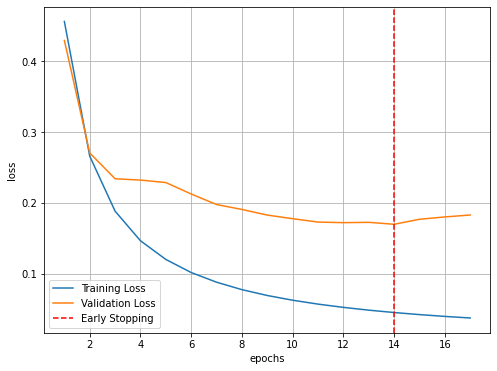

In [16]:
# Visualizing the loss as the network trained

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))

plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')

plt.xlabel('epochs')
plt.ylabel('loss')

# find position of lowest validation loss
minposs = avg_valid_losses.index(min(avg_valid_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping')

plt.grid(True)
plt.legend()

plt.show()

## Test
<font size="4">
  Now you can compute the performance of the model on the unseen test data.
  
  </font>

In [0]:
# define evaluation metrics (acc, precision, recall, and f1-score)
from sklearn.metrics import precision_recall_fscore_support

class Evaluate():
    def __init__(self, out, labels):
        self.out = out.numpy().flatten()
        self.labels = labels.numpy().flatten()
    def accuracy(self):
        nb_correct = sum(y_t==y_p for y_t, y_p in zip(self.labels, self.out))
        nb_true = len(self.labels)
        score = nb_correct / nb_true
        return score
    def precision_recall_fscore(self, tag_list, average='macro'):
        return precision_recall_fscore_support(self.labels, self.out, 
                                                  average=average,labels=tag_list)[:-1]

In [18]:
# evaluate the model on test set 

model.load_state_dict(torch.load('/content/drive/My Drive/DLinNLP/best_model_state.pkl'))

all_preds = torch.LongTensor().to(device)
all_labels = torch.LongTensor().to(device)

with torch.no_grad():
    for sent, target in test_data_generator:
        sent, target = sent.to(device), target.to(device)
        tag_scores = model(sent)
        
        predict = tag_scores.data.max(2, keepdim=True)[1]        
        all_preds = torch.cat([all_preds, predict])
        all_labels = torch.cat([all_labels,target])
    
    all_preds, all_labels = all_preds.cpu(), all_labels.cpu()
    all_preds = all_preds.squeeze(dim=-1)
    evaluator = Evaluate(all_preds, all_labels)
    print('Overall Results on the Test set:')
    print('Accuracy\t{}'.format(evaluator.accuracy()))
    pr, rc, fm = evaluator.precision_recall_fscore(tag_list=[1,2,3]) # we ignore pad  
    print('Precision\t{}\nRecall\t\t{}\nF1-score\t{}'.format(pr,rc,fm))
    
    print('\n==================\n')
    
    print('# Results ignoring PAD and O:\n')
    tag_list = [1,2] # we ignore both pad and O
    pr, rc, fm = evaluator.precision_recall_fscore(tag_list)
    print('Precision\t{}\nRecall\t\t{}\nF1-score\t{}'.format(pr,rc,fm))         

Overall Results on the Test set:
Accuracy	0.11195343794930149
Precision	0.5533463417592027
Recall		0.8742638968983522
F1-score	0.5951577086974141


# Results ignoring PAD and O:

Precision	0.7817235221963486
Recall		0.830291345921701
F1-score	0.8049564466662773
